# Using LangGraph API

We can connect to our data enrichment agent using the LangGraph API.

The LangGraph API serves as the back-end for LangGraph Studio.

The Studio UI provides a URL (lower left corner) that we can use to connect to the API using the LangGraph SDK. 

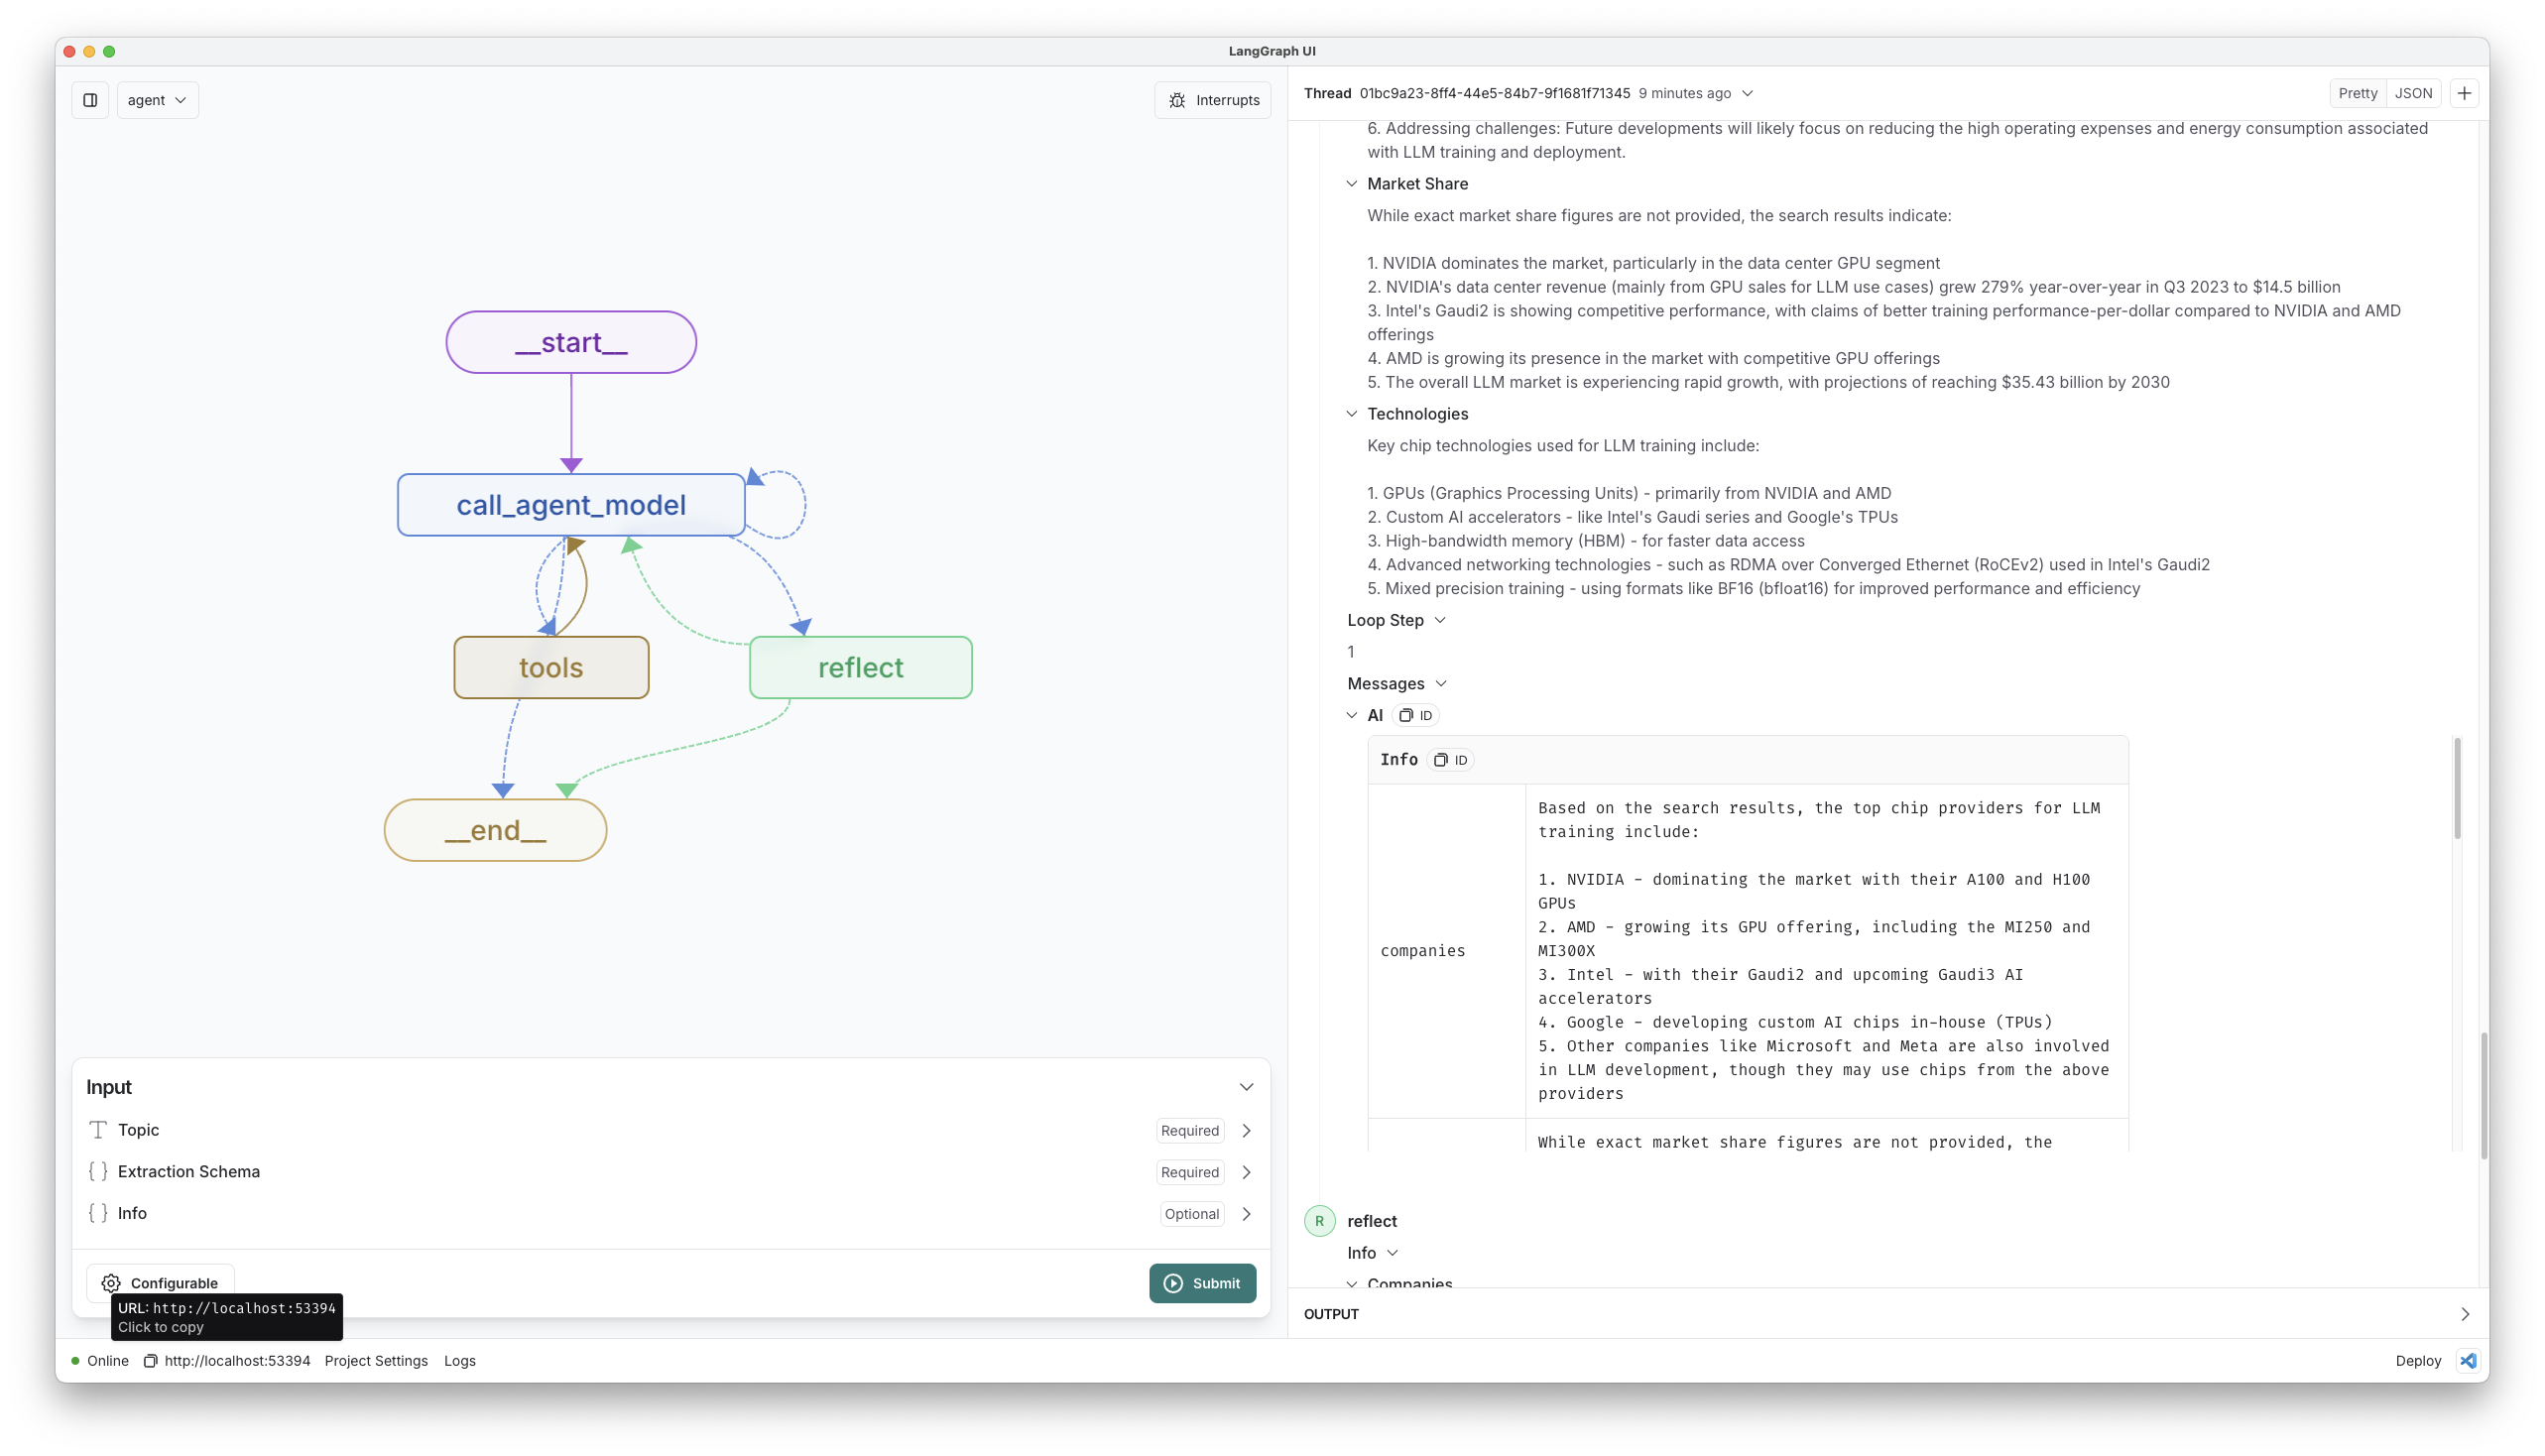

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph_sdk

In [3]:
from langgraph_sdk import get_client

client = get_client(url="http://localhost:8123")

In [5]:
topic = """Strategic focuses, key investments, acquisitions, and other major events for {company} and its subsidiaries around the globe. 

Return a compilation of recent major events from some countries and brands that {company} owns. Return 20-30 results. Make sure to include only results from August and September 2024.
Skip ESG news. Prioritize news about the company's brands, business operations, and other major events.
"""

In [6]:
schema = {
    "type": "object",
    "properties": {
        "key_news": {
            "type": "array",
            "items": {
                "type": "object",
                "properties": {
                    "name": {"type": "string", "description": "Event name"},
                    "source": {
                        "type": "string",
                        "description": "source link,",
                    },
                    "date": {
                        "type": "string",
                        "description": "date of the article/news item",
                    },
                    "short_description": {
                        "type": "string",
                        "description": "Brief summary of the news item, capturing the essence of the news item",
                    },
                    "key_takeaways": {
                        "type": "string",
                        "description": "What particular actionable insights and takeaways can an AlcoBev global executive team glean from this news item?",
                    },
                },
                "required": ["url", "short_description", "key_takeaways"],
            },
            "description": "List of news items",
        }
    },
    "required": ["key_news"],
}

Note that we can pass any configuration parameters in [configuration.py](../src/enrichment_agent/configuration.py) via `configurable` key in the input.

In [9]:
from langchain_core.messages import convert_to_messages

# Thread
thread = await client.threads.create()

# Model
#llm = "openai/gpt-4o"
llm = "anthropic/claude-3-5-sonnet-20240620"


# Stream
async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={
        "topic": topic.format(company="Heineken"),
        "extraction_schema": schema,
        "configurable": {"model_name": llm, "max_loops": 50, "max_info_tool_calls": 10,"max_search_results": 50},
    },
    stream_mode="values",
):
    messages = event.data.get("messages", None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print("=" * 25)

content=[{'id': 'toolu_01DywfqETXJn6yV3eY9PtXWj', 'input': {'query': 'Heineken strategic focuses, key investments, acquisitions, major events, global subsidiaries, brands, business operations August September 2024 -ESG'}, 'name': 'search', 'type': 'tool_use'}] additional_kwargs={'additional_kwargs': {}, 'response_metadata': {'id': 'msg_01Jb7bJKAex6GuijZmXxmiCr', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 1174, 'output_tokens': 67}}, 'example': False, 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 1174, 'output_tokens': 67, 'total_tokens': 1241, 'input_token_details': {}}} response_metadata={} id='run-0b8a628a-6a28-4261-9b8d-ba759ca7e0df-0' tool_calls=[{'name': 'search', 'args': {'query': 'Heineken strategic focuses, key investments, acquisitions, major events, global subsidiaries, brands, business operations August September 2024 -ESG'}, 'id': 'toolu_01DywfqETXJn6yV3eY9PtXWj', 'type': 'tool_call'}]
co

CancelledError: 

In [11]:
from langgraph_sdk import get_client
import asyncio

# Initialize the client
client = get_client(url="http://localhost:8123")  # Update this URL as needed

async def run_search_agent_for_company(company):
    try:
        # Get default assistant
        assistants = await client.assistants.search()
        assistant = [a for a in assistants if not a["config"]][0]
        assistant_id = assistant["assistant_id"]
        print(f"Using assistant with ID: {assistant_id} for {company}")

        # Create a thread
        thread = await client.threads.create()
        thread_id = thread["thread_id"]
        print(f"Created thread with ID: {thread_id} for {company}")

        input_data = {
            "topic": topic.format(company=company),
            "extraction_schema": schema,
            "configurable": {
                "model_name": "anthropic/claude-3-5-sonnet-20240620",
                "max_loops": 50,
                "max_info_tool_calls": 10,
                "max_search_results": 200
            },
            "messages": [
                {
                    "role": "user", 
                    "content": f"Make a plan to complete the request for {company}"
                }
            ],
            'current_plan': f"Initial plan: Analyze the request for {company}",
            'iteration_number': 0,
        }

        # Execute a run on the thread
        async for chunk in client.runs.stream(
            thread_id,
            assistant_id,
            input=input_data,
            stream_mode="updates",
            config={
                "recursion_limit": 50
            }
        ):
            if chunk.data and chunk.event != "metadata":
                print(f"{company}: {chunk.data}")
                if 'error' in chunk.data:
                    print(f"Error encountered for {company}: {chunk.data['error']}")
                    print(f"Error message: {chunk.data['message']}")
                    break

        # Get final state
        final_state = await client.threads.get_state(thread_id)
        print(f"Final results for {company}:", final_state)
        return final_state

    except Exception as e:
        print(f"An error occurred for {company}: {str(e)}")

async def run_all_companies():
    companies = [
        "Mars", "Hershey's", "Nestlé", "Ferrero", "Mondelez International",
        "Lindt & Sprüngli", "Perfetti Van Melle", "Haribo", "Meiji", "Tootsie Roll Industries",
        "Ghirardelli Chocolate Company", "Godiva Chocolatier", "Cadbury", "Jelly Belly Candy Company",
        "Russell Stover Chocolates", "Storck", "Pladis", "Arcor", "Lotte Confectionery", "Ezaki Glico",
        "Fazer", "Cloetta", "Ritter Sport", "Tony's Chocolonely", "Guylian", "Cemoi", "Leaf Brands",
        "Ferrara Candy Company", "Just Born", "Bahlsen"
    ]
    
    tasks = []
    results = {}
    for company in companies:
        task = asyncio.create_task(run_search_agent_for_company(company))
        tasks.append((company, task))
    
    for company, task in tasks:
        result = await task
        results[company] = result

    return results

# Run the async function for all companies and get the results
search_results = await run_all_companies()

Using assistant with ID: fe096781-5601-53d2-b2f6-0d3403f7e9ca for Ferrero
Using assistant with ID: fe096781-5601-53d2-b2f6-0d3403f7e9ca for Ghirardelli Chocolate Company
Using assistant with ID: fe096781-5601-53d2-b2f6-0d3403f7e9ca for Godiva Chocolatier
Using assistant with ID: fe096781-5601-53d2-b2f6-0d3403f7e9ca for Perfetti Van Melle
Using assistant with ID: fe096781-5601-53d2-b2f6-0d3403f7e9ca for Storck
Using assistant with ID: fe096781-5601-53d2-b2f6-0d3403f7e9ca for Tootsie Roll Industries
Using assistant with ID: fe096781-5601-53d2-b2f6-0d3403f7e9ca for Cadbury
Using assistant with ID: fe096781-5601-53d2-b2f6-0d3403f7e9ca for Nestlé
Using assistant with ID: fe096781-5601-53d2-b2f6-0d3403f7e9ca for Mondelez International
Using assistant with ID: fe096781-5601-53d2-b2f6-0d3403f7e9ca for Jelly Belly Candy Company
Using assistant with ID: fe096781-5601-53d2-b2f6-0d3403f7e9ca for Haribo
Using assistant with ID: fe096781-5601-53d2-b2f6-0d3403f7e9ca for Meiji
Using assistant with ID:

In [ ]:
current_state = await client.threads.get_state(thread["thread_id"])

In [8]:
from IPython.display import Markdown, display


def format_llm_chip_info(data):
    markdown_text = "# Top 5 Chip Providers for LLM Training\n\n"

    for company in data["companies"]:
        markdown_text += f"""
## {company['name']}

**Key Technologies:** {company['technologies']}

**Market Share:** {company['market_share']}

**Key Powers:** {company.get('key_powers', 'Not specified')}

**Future Outlook:** {company['future_outlook']}

---
"""

    return Markdown(markdown_text)


# Display the formatted markdown
display(format_llm_chip_info(current_state["values"]["info"]))

# Top 5 Chip Providers for LLM Training


## NVIDIA

**Key Technologies:** GPU accelerators (A100, H100, GH200, Blackwell B200)

**Market Share:** Over 80% of the high-end AI chip market

**Key Powers:** Scale Economies, Network Economies, Branding

**Future Outlook:** Strong growth potential with continued innovation in AI-specific hardware, including the recently announced Blackwell B200 GPU

---

## AMD

**Key Technologies:** MI250 and MI300X GPUs

**Market Share:** Growing presence in AI chip market, with performance reportedly close to NVIDIA in some benchmarks

**Key Powers:** Scale Economies, Counter Positioning

**Future Outlook:** Accelerating roadmap development to compete in the AI market, potential for significant growth

---

## Intel

**Key Technologies:** Gaudi2 and upcoming Gaudi3 AI accelerators

**Market Share:** Emerging player in AI chip market, with Gaudi3 potentially competitive with NVIDIA's H100

**Key Powers:** Scale Economies, Process Power

**Future Outlook:** Promising outlook with Gaudi3 chips, aiming to offer performance comparable to NVIDIA's offerings at a potentially lower cost

---

## Google

**Key Technologies:** Tensor Processing Units (TPUs) v4 and v5e

**Market Share:** Significant player for in-house use and Google Cloud customers

**Key Powers:** Network Economies, Process Power, Scale Economies

**Future Outlook:** Continued development of TPUs with v5e offering up to 4x greater performance per dollar for inference compared to alternatives

---

## Groq

**Key Technologies:** Language Processing Unit (LPU) Inference Engine

**Market Share:** Emerging player focusing on inference, gaining attention for high-speed performance

**Key Powers:** Counter Positioning, Process Power

**Future Outlook:** Potential for rapid adoption among startups due to speed and cost-effectiveness in LLM inference, claiming to serve Mixtral at nearly 500 tokens/second

---


The LangGraph API allows us to interact with the agent in a programmatic way.

It has many capabilities, including as shown [here](https://langchain-ai.github.io/langgraph/cloud/concepts/api/), which include [cron-jobs](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#cron-jobs).

So, the agent could be run on a schedule or even hosted via [LangGraph cloud](https://langchain-ai.github.io/langgraph/cloud#overview).                                                                                                 